In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts_amarel as ef
from utils import create_mask as cm
from utils import ed_plotting as eplt

# load GPU
gpu_id = '0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

from models.poissonian_gp import EbinPoissonModel

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''
Figure 2. Corner plot and normalization histograms

source: notebooks/0a, 0b, 0c
'''

'\nFigure 2. Corner plot and normalization histograms\n\nsource: notebooks/0a, 0b, 0c\n'

In [3]:
# load GPU
gpu_id = '0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

# name of the synthetic directory
sim_name = 'canon_g1p2_ola_v2'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 5.23457
gp_id = 1.16
blg_id = -1
mod_id = 11
svi_id = 300 # (24,25) =  (no outer roi, outer roi)
sim_seed = 1000
svi_seed = 0

# load data directory
data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

0

In [4]:
# import all saved model parameters from python file
fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

/
    settings_7p1234567_5p23457_1p16_-1_11_300_1000_0.py
    __init__.py
    ebin10_smp_svi_0.1_20000_mvn_8_1000_0.p
    summary.txt
__pycache__/
    settings_7p1234567_5p23457_1p16_-1_11_300_1000_0.cpython-311.pyc


In [5]:
# load model using stored parameters
ebinmodel = EbinPoissonModel(
        # important parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg = is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,

        # default parameters
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        blg_names = blg_names,
        dif_names = dif_names,
        )
ebinmodel.config_model(ebin=ebin)

In [6]:
# load saved data from GP -> Data fit
fit_file_name = ('ebin' + str_ebin + '_smp_svi_' + 
            str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

samples_dict, svi_results = pickle.load(open(fit_dir + fit_file_name, 'rb'))

# generate temp_sample_dict
all_temp_names = ['iso', 'psc', 'bub', 'pib', 'ics', 'blg', 'nfw', 'dsk', 'gp']
names = list(samples_dict.keys())
temp_sample_dict = {k: samples_dict[k] for k in all_temp_names if k in names}
temp_sample_dict_cmask = {k: samples_dict[k + '_cmask'] for k in all_temp_names if k in names}

In [7]:
# load true data if exits
if data_file != 'fermi_data_sum':
    temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()
else:
    pass

In [8]:
u_sample = samples_dict['log_rate_u'][0]
f_sample = np.log(samples_dict['gp_cmask'][0])

In [9]:
u_sample.max(), np.log(f_sample.max())

(Array(3.9984577, dtype=float32), 1.3938187)

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:621: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(custom_xtick_labels, fontname=fontname)
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufu

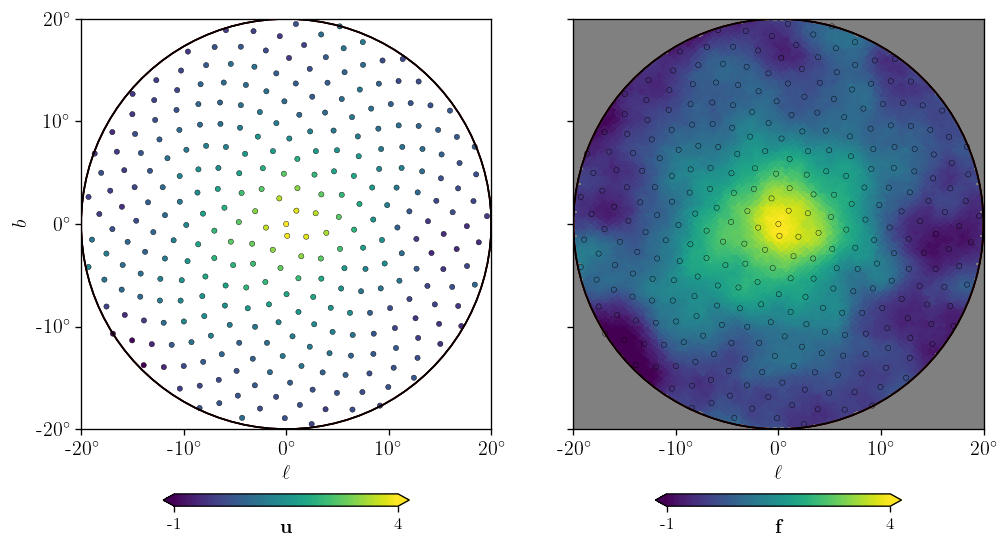

In [10]:
# Bottom: Data Processing 
xu_f = ebinmodel.xu_f
xu_f_r = np.deg2rad(xu_f)

mask = cm.make_mask_total(
        nside=128,
        mask_ring=True,
        outer = 20.,
        inner = 0.,
    )
m = ef.convert_masked_array_to_hp_array(f_sample, mask, log_option = False, nside = 128)

fig, ax = plt.subplots(figsize=(8, 6), dpi= 120, nrows = 1, ncols = 2) # DEFINING AXES FROM HERE DOES NOT WORK SEE SUBPLOT ARGUMENT BELOW

plt.axes(ax[0])
eplt.inner_roi_map(m, title = None, vmin = -1, vmax = 4, subplot = 121, unit = '$\\mathbf{u}$')
circle1 = plt.Circle((0, 0), 20., color='white')
plt.gca().add_patch(circle1)
plt.scatter(xu_f_r[:,0], xu_f_r[:,1], c = u_sample, edgecolors = 'k', s = 10, lw = 0.25, cmap = 'viridis')

plt.axes(ax[1])
eplt.inner_roi_map(m, title = None, vmin = -1, vmax = 4, subplot = 122, unit = '$\\mathbf{f}$', display_y_info = False)
plt.scatter(xu_f_r[:,0], xu_f_r[:,1], facecolors = 'none', edgecolors = 'k', s = 10, lw = 0.25)

In [11]:
pickle.dump(
    (xu_f, xu_f_r, u_sample, f_sample),
    open('../figures/data/appdata_inducing.p', 'wb')
)